<a href="https://colab.research.google.com/github/Tinddd28/labs-iadnmo-/blob/main/lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа №4 "Классификация изображений. Сверточные сети. Полносвязные сети с предобучением и дообучением"

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tqdm import tqdm
import shutil

In [14]:
!unzip archive.zip

Archive:  archive.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: fl

In [11]:
flowers_directory = "flowers"

train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

root = "dataset"
train_folder_name = "train"
validation_folder_name = "validation"
test_folder_name = "test"

In [15]:
os.mkdir(root)
os.mkdir(os.path.join(root, train_folder_name))
os.mkdir(os.path.join(root, validation_folder_name))
os.mkdir(os.path.join(root, test_folder_name))

for flower_folder in tqdm(os.listdir(flowers_directory)):
    os.mkdir(os.path.join(root, train_folder_name, flower_folder))
    os.mkdir(os.path.join(root, validation_folder_name, flower_folder))
    os.mkdir(os.path.join(root, test_folder_name, flower_folder))

    flower_images_path = os.listdir(os.path.join(flowers_directory, flower_folder))

    train_size = int(train_ratio * len(flower_images_path))
    validation_size = int(validation_ratio * len(flower_images_path))
    test_size = int(test_ratio * len(flower_images_path))

    for image_path in flower_images_path[:train_size]:
        shutil.copyfile(os.path.join(flowers_directory, flower_folder, image_path), os.path.join(root, train_folder_name, flower_folder, image_path))

    for image_path in flower_images_path[train_size:train_size + validation_size]:
        shutil.copyfile(os.path.join(flowers_directory, flower_folder, image_path), os.path.join(root, validation_folder_name, flower_folder, image_path))

    for image_path in flower_images_path[train_size + validation_size:]:
        shutil.copyfile(os.path.join(flowers_directory, flower_folder, image_path), os.path.join(root, test_folder_name, flower_folder, image_path))


100%|██████████| 5/5 [00:00<00:00,  9.59it/s]


In [16]:
for data in [train_folder_name, validation_folder_name, test_folder_name]:
    print(f"==== {data} ====")
    for flower_folder in os.listdir(os.path.join(root, data)):
        print(f"{flower_folder}: {len(os.listdir(os.path.join(root, data, flower_folder)))}")
    print()

==== train ====
dandelion: 631
daisy: 458
rose: 470
tulip: 590
sunflower: 439

==== validation ====
dandelion: 210
daisy: 152
rose: 156
tulip: 196
sunflower: 146

==== test ====
dandelion: 211
daisy: 154
rose: 158
tulip: 198
sunflower: 148



In [22]:
train = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(root, train_folder_name),
    batch_size=32,
    image_size=(128, 128),
)
validation = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(root, validation_folder_name),
    batch_size=32,
    image_size=(128, 128),
)
test = tf.keras.utils.image_dataset_from_directory(
    directory=os.path.join(root, test_folder_name),
    batch_size=32,
    image_size=(128, 128),
)

Found 2588 files belonging to 5 classes.
Found 860 files belonging to 5 classes.
Found 869 files belonging to 5 classes.


In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),

    # Аугментация данных
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),

    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax"),
])

In [24]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 128, 128, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_1 (RandomZoom)  (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                 

In [25]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=10),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="models/best_model_conv.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
    ),
]

In [26]:
history = model.fit(
    train,
    epochs=1000,
    validation_data=validation,
    callbacks=callbacks,
)

Epoch 1/1000
81/81 [==============================] - 42s 497ms/step - loss: 1.3625 - accuracy: 0.3833 - val_loss: 1.2743 - val_accuracy: 0.4523
Epoch 2/1000
81/81 [==============================] - 39s 481ms/step - loss: 1.1741 - accuracy: 0.5062 - val_loss: 1.2350 - val_accuracy: 0.4744
Epoch 3/1000
81/81 [==============================] - 37s 452ms/step - loss: 1.0246 - accuracy: 0.5896 - val_loss: 1.1787 - val_accuracy: 0.5477
Epoch 4/1000
81/81 [==============================] - 38s 465ms/step - loss: 0.9568 - accuracy: 0.6171 - val_loss: 1.1089 - val_accuracy: 0.5849
Epoch 5/1000
81/81 [==============================] - 38s 467ms/step - loss: 0.8936 - accuracy: 0.6426 - val_loss: 0.9504 - val_accuracy: 0.6523
Epoch 6/1000
81/81 [==============================] - 39s 476ms/step - loss: 0.8731 - accuracy: 0.6604 - val_loss: 1.0298 - val_accuracy: 0.6419
Epoch 7/1000
81/81 [==============================] - 38s 465ms/step - loss: 0.8405 - accuracy: 0.6673 - val_loss: 0.9504 - val_ac

In [27]:
best_model_conv = tf.keras.models.load_model("models/best_model_conv.keras")

In [28]:
loss, accuracy = best_model_conv.evaluate(test)
print(f"Loss: {loss:.3f}")
print(f"Accuracy: {accuracy:.3f}")

28/28 [==============================] - 3s 85ms/step - loss: 0.8070 - accuracy: 0.7342
Loss: 0.807
Accuracy: 0.734


In [29]:
def plot(history):
    epochs = len(history.history['loss'])
    epochs_range = range(epochs)


    loss = history.history['loss']
    val_loss = history.history['val_loss']


    plt.cla()
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    if 'accuracy' not in history.history.keys():
        return

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.cla()
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

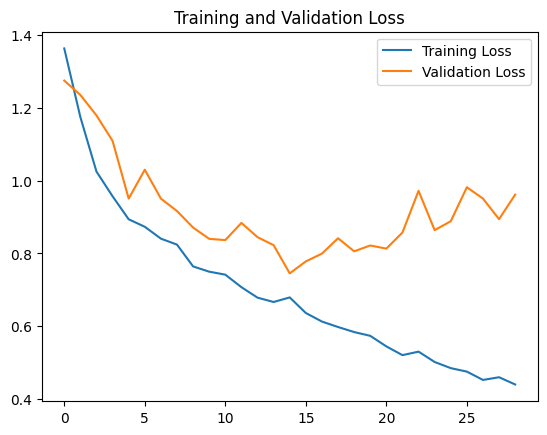

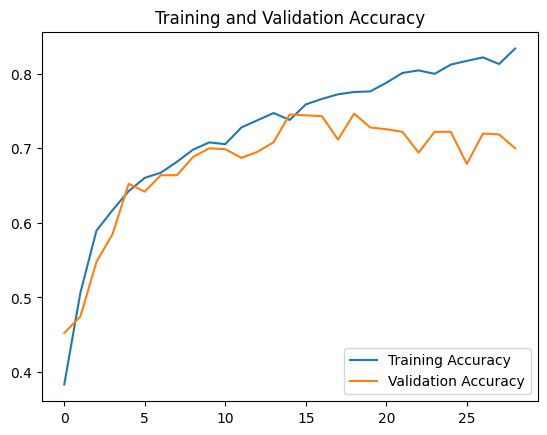

In [30]:
plot(history)